# Plant Seedling Classification
**Image classification using CNNs in Keras**

## Context
Can we differentiate a weed from a crop seedling?<br/>
The ability to do so effectively can mean better crop yields and better stewardship of the environment.</br>
The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of unique plants belonging to 12 species at several growth stages

## Objective
Using the techniquies learned during the Computer Vision course, build a model to correctly classify the images from the dataset into 12 classes

## Data Description:
We are provided with a dataset of images of plant seedlings at various stages of grown.<br/> 
- Each image has a filename that is its unique id. 
- The dataset comprises 12 plant species. 

The goal of the project is to create a classifier capable of determining a plant's species from a photo.

In [39]:
# Course: Introduction to Computer Vision
# Project: Plant Seed Classification
# Student: Sameer Girolkar
# Date: Mar 22, 2022

In [40]:
# Use nb_black for well formatted code
# Comment this out if using Google Colab 
# %load_ext nb_black

In [41]:
# Import the required librariies

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, 
    Dropout, 
    Flatten, 
    Conv2D, 
    MaxPool2D, 
    BatchNormalization, 
    Activation, 
    Input, 
    LeakyReLU
)
from tensorflow.keras import losses, optimizers, backend
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from tensorflow.keras.optimizers import RMSprop,Adam #optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns # for data visualization 
from PIL import Image

import numpy as np
import pandas as pd
import os
import random

## Reading the data

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# Read the images and labels from filess
images = np.load("/content/drive/MyDrive/images.npy")
labels = pd.read_csv("/content/drive/MyDrive/Labels.csv")

## EDA

In [44]:
print(f"Count of images: {len(images)}")
print(f"Shape of images: {images[0].shape}")
print(f"Count of labels: {len(labels)}")

Count of images: 4750
Shape of images: (128, 128, 3)
Count of labels: 4750


### Observations:
- There are 4750 Images and labels
- Each images is 128 pixel x 128 pixel in size
- Dataset has color images

In [45]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None, hue=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    hue: Grouping variable
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 3, 3))
    else:
        plt.figure(figsize=(n + 3, 3))

    plt.xticks(rotation=45, fontsize=10)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
        hue=hue,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

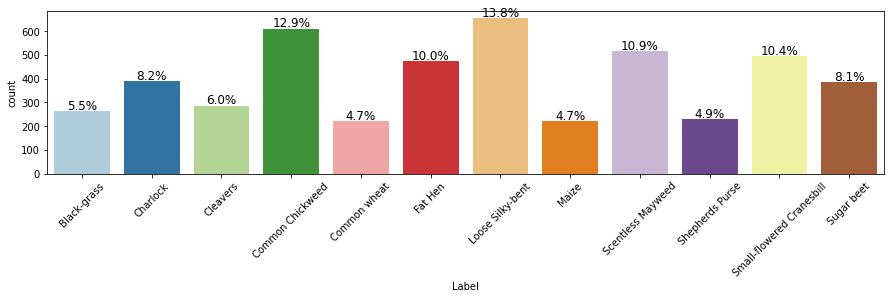

In [46]:
# check the distribution of the classes in the data
labeled_barplot(labels, 'Label', perc=True)

### Observations
- Each category of plants are have between 4% to 14% of the images
- Loose Silky Bent has maximum 13.8% of images

## Data Visualization

In [47]:
data = labels.copy()
data["Image"] = images.tolist()

In [48]:
data.sample(3)

,Label,Image
3817,Maize,"[[[69, 98, 110], [46, 67, 87], [52, 72, 89], [..."
1075,Shepherds Purse,"[[[57, 75, 92], [52, 67, 91], [42, 64, 96], [4..."
296,Small-flowered Cranesbill,"[[[51, 69, 87], [64, 79, 91], [64, 77, 90], [5..."


In [49]:
# Creating a user defined function to calculate and plot the mean image of each category 
def find_mean_img(full_mat):               
    mean_img = np.mean(full_mat, axis = 0)  # Taking the mean of pixel values for each category and storing in mean_img
    mean_img = mean_img.reshape((128, 128))  # Reshaping the image to 150x150
  
    return mean_img

CATEGORIES=labels['Label'].unique()        # Storing all the unique labels
label_imeges={ i:[] for i in CATEGORIES}               # Here we are creating a dictionary with keys as unique categories and values as list for each category

for i in labels.index:
    gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY) 
    img = cv2.resize(gray,(128,128))    # Reshaping the image to 150x150
    label_imeges[labels['Label'][i]].append(img)        # Here we are appending each image of its category to its respective list in the dictionary


# Looping over each category from the keys in the dictionary 
# and adding the mean image of each category to the newly created dicct{label: mean_img}
mean_img_dict={}
for lbl, _ in label_imeges.items():  
    mean_img_dict[lbl] = find_mean_img(label_imeges[lbl])
    
    

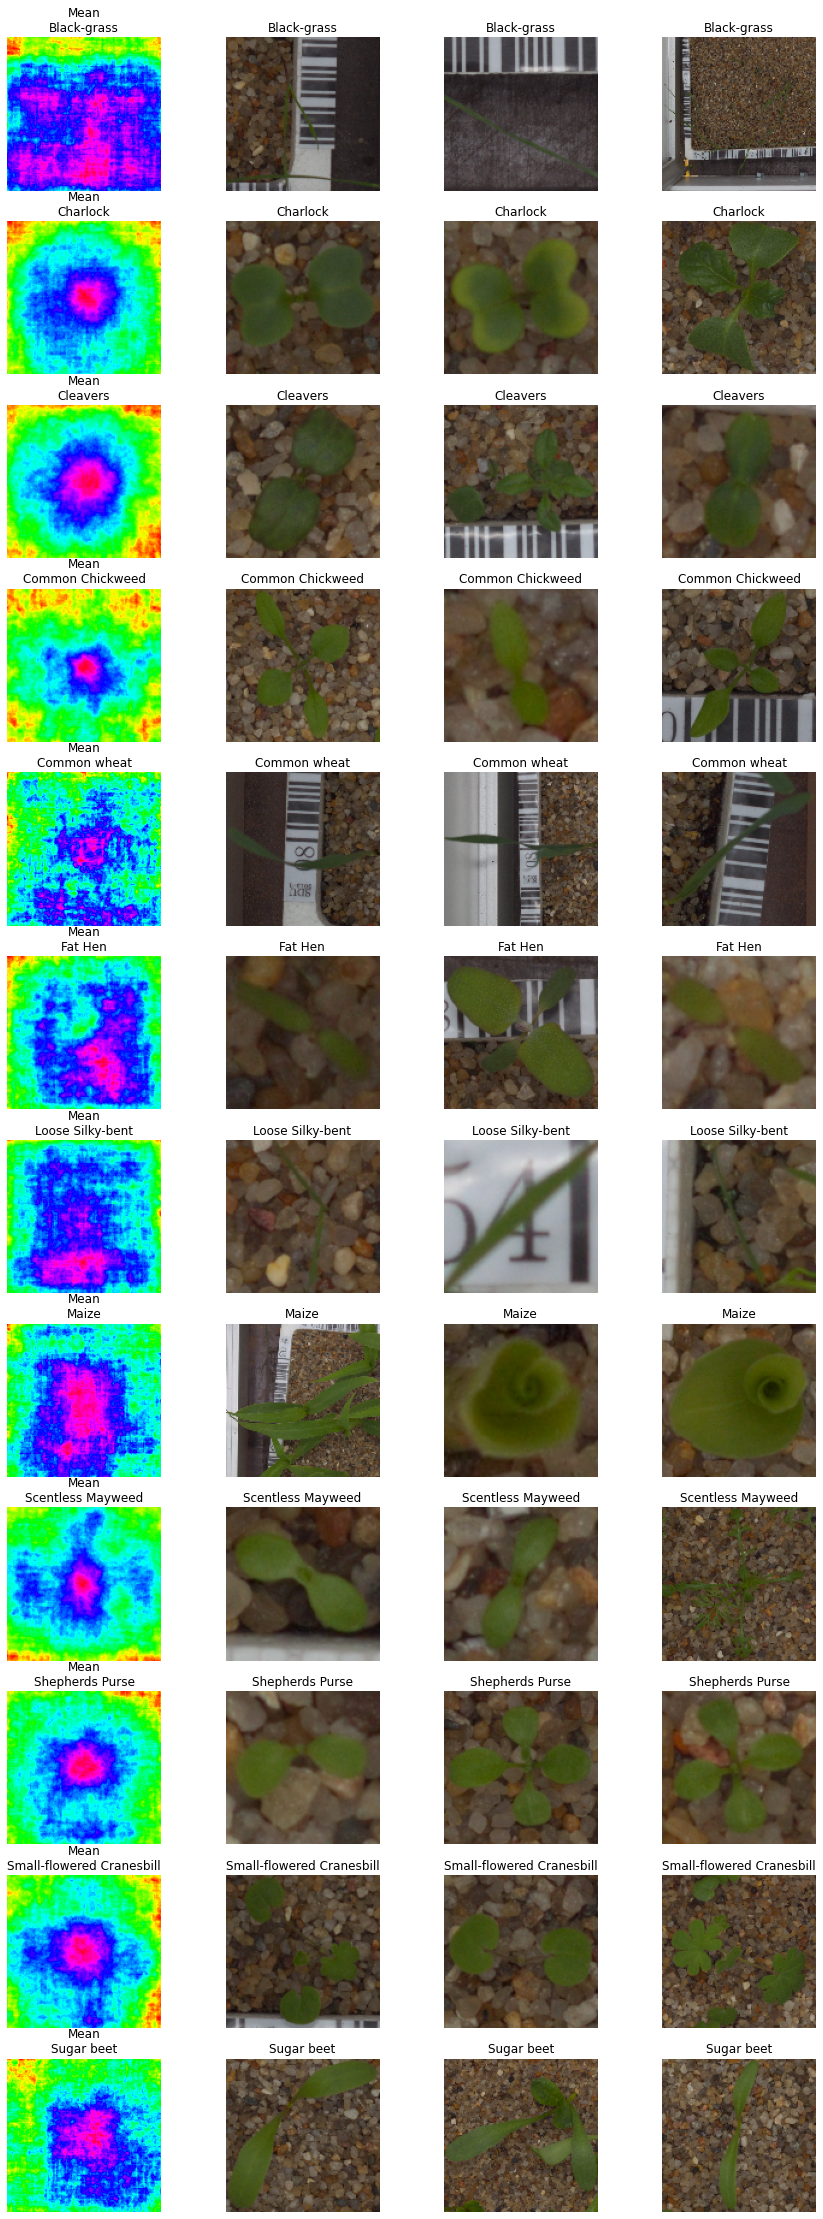

In [50]:
# Plot the mean image and sample images for each group

i = 0
fig = plt.figure(figsize = (15, 40))
groups = data.groupby("Label")
for lbl, grp in groups:
    grp.drop("Label", axis=1, inplace=True)
    ax = fig.add_subplot(12, 4, i+1)
    m = mean_img_dict[lbl]
    plt.imshow(m, cmap='hsv_r') 
    plt.title(f"Mean\n{lbl}")
    plt.axis('off')
    i += 1
    for index, row in grp.sample(3).iterrows():
        ax = fig.add_subplot(12, 4, i+1)
        img = np.float32(np.array(row["Image"]))/255.0
        d = cv2.resize(img,(128,128))
        plt.imshow(cv2.cvtColor(d, cv2.COLOR_BGR2RGB))
        plt.title(lbl)
        plt.axis('off')
        i += 1
        
plt.show()

### Observations
- Some seedlings look similar to each other. e.g.
    - Black grass and Loose Silky Bent seedlings look similar
    - Clevers and Small-flowred cranesbill loook similar
    - Fat hen, Scentless Mayweed and Sugar beet seedlings look similar
- Some seedling images differ within the group. e.g.
    - Shepherds purse images look different wiithin the group
- In this speeecific case the mean image does not seem to provide ay clear information

## Data Preporcessing

### Apply Gaussian Blurring

In [51]:
images_new = images.copy()
# Now we apply the gaussian blur to each 28x28 pixels array (image) to reduce the noise in the image
for idx, img in enumerate(images):
    # Here we are trying to use blurring kernel_size 5x5, we can also try to use 3x3 and observe the difference, 
    # how they are different from the blurred images with 3x3.
    images_new[idx] = cv2.GaussianBlur(img, (5, 5), 0) 


### Data Normalization

In [52]:
images_new = images_new / 255.0

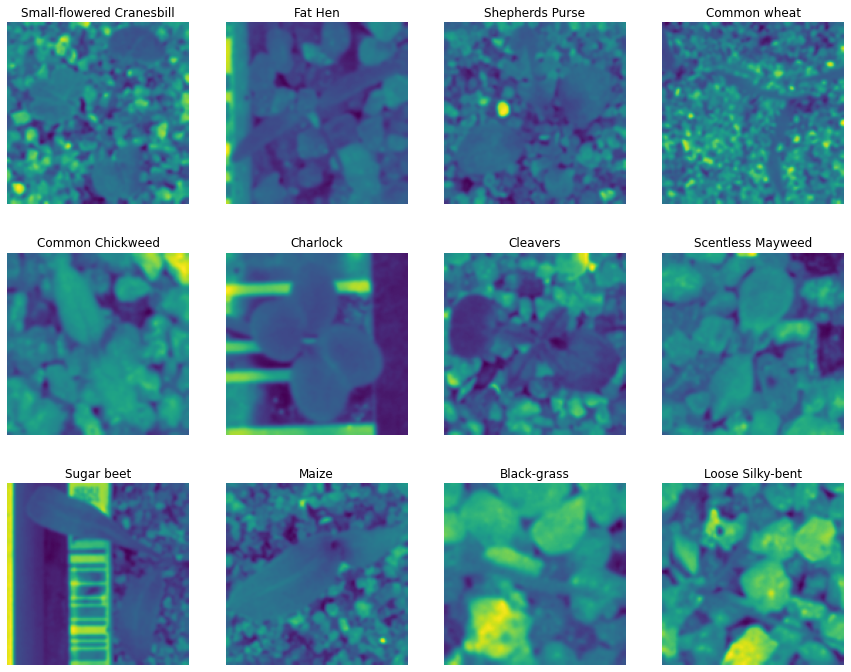

In [53]:
# Storing all the unique labels
CATEGORIES=labels['Label'].unique()    

#  creating a dictionary with keys as unique categories and values as list for each category
label_new_imeges={ i:[] for i in CATEGORIES}    

# appending each image of its category to its respective list in the dictionary
for i in labels.index:
    label_new_imeges[labels['Label'][i]].append(images_new[i])        

# Looping over each category from the keys in the dictionary 
# and visualizing one image of each category 
i = 0
fig = plt.figure(figsize = (15, 12))
for lbl, lbl_new_imeges in label_new_imeges.items(): 
    im = random.choice(lbl_new_imeges)
    ax = fig.add_subplot(3, 4, i+1)
    im = np.float32(im)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY))
    plt.title(lbl)
    plt.axis('off')
    i += 1
plt.show()

### Split train and test data

In [54]:
# Split the data into traing and test sets
X_train, X_test, y_train, y_test = train_test_split(images_new, labels, test_size=0.2, random_state=1, stratify=labels)

In [55]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3800, 128, 128, 3)
X_test shape: (950, 128, 128, 3)
y_train shape: (3800, 1)
y_test shape: (950, 1)


Training Data distribution


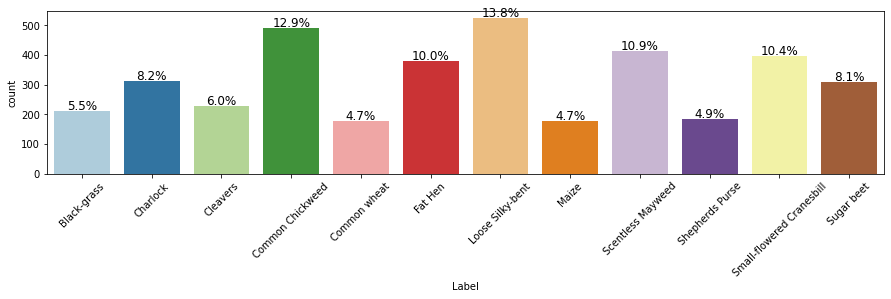

Testing Data distribution


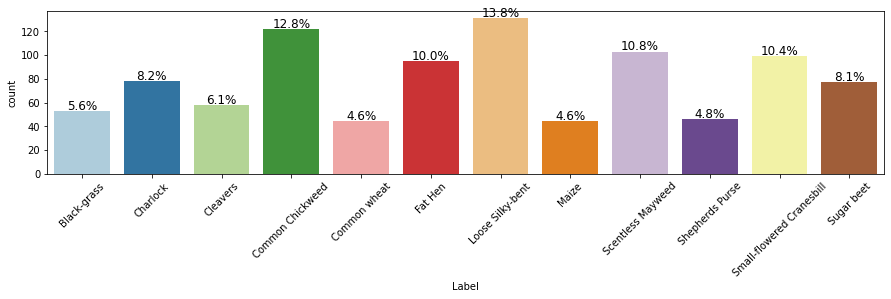

In [56]:
# check the distribution of the classes in the train and test data
print("Training Data distribution")
labeled_barplot(y_train, 'Label', perc=True)
print("Testing Data distribution")
labeled_barplot(y_test, 'Label', perc=True)

#### Obsrvations:
- Images classs distribution in Train and Test data is matching the original dataset

### Encoding Target Variable

In [57]:
le = LabelBinarizer()
# Applying fit_transform on train target variable
y_train_e = le.fit_transform(np.array(y_train))
# Applying only transform on test target variable
y_test_e = le.transform(np.array((y_test)))

## Model Building

### Base Model

In [58]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [59]:
# initialized a sequential model
model_1 = Sequential()

# adding first conv layer
model_1.add(
    Conv2D(
        filters = 256,
        kernel_size = (5,5),
        padding = 'Same', 
        activation ='relu', 
        input_shape = (128,128,3)
    )
)  

# adding max pooling 
model_1.add(MaxPool2D(pool_size=(2,2)))
#  adding dropout 
model_1.add(Dropout(0.25))

#  adding second conv layer 
model_1.add(
    Conv2D(
        filters = 128, 
        kernel_size = (3,3),
        padding = 'Same', 
        activation ='relu'
    )
)
model_1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_1.add(Dropout(0.25))

#  adding third conv layer 
model_1.add(
    Conv2D(
        filters = 128, 
        kernel_size = (3,3),
        padding = 'Same',
        activation ='relu'
    )
)
model_1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_1.add(Dropout(0.3))

# flattening the 3-d output
model_1.add(Flatten())

# adding a fully connected dense layer
model_1.add(
    Dense(
        512, 
        activation = "relu"
    )
)
model_1.add(Dropout(0.5))

# adding the output layer 
model_1.add(Dense(12, activation = "softmax"))

In [60]:
# printing the model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 256)     19456     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)       0

In [61]:
# Using Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compiling the model
model_1.compile(
    optimizer = optimizer , 
    loss = "categorical_crossentropy",
    metrics=["accuracy"]
)

In [62]:
# Fitting the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model_1.fit(
    X_train, 
    y_train_e,  
    epochs=30, 
    batch_size=200,
    validation_split=0.20,
    callbacks=[es, mc]
) 

Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 2.5816 - accuracy: 0.1148
Epoch 1: val_accuracy improved from -inf to 0.17237, saving model to best_model.h5
16/16 [==============================] - 6s 348ms/step - loss: 2.5816 - accuracy: 0.1148 - val_loss: 2.4255 - val_accuracy: 0.1724
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 2.4425 - accuracy: 0.1352
Epoch 2: val_accuracy did not improve from 0.17237
16/16 [==============================] - 5s 302ms/step - loss: 2.4425 - accuracy: 0.1352 - val_loss: 2.4244 - val_accuracy: 0.1474
Epoch 3/30
16/16 [==============================] - ETA: 0s - loss: 2.3767 - accuracy: 0.1780
Epoch 3: val_accuracy improved from 0.17237 to 0.27368, saving model to best_model.h5
16/16 [==============================] - 5s 325ms/step - loss: 2.3767 - accuracy: 0.1780 - val_loss: 2.2799 - val_accuracy: 0.2737
Epoch 4/30
16/16 [==============================] - ETA: 0s - loss: 2.1633 - accuracy: 0.2592
Epoch 4: va

### Observations
- First model seems to be performing well though it seems to be over fitting
- Best Training accuracy: 88%
- Best Test Accuracy: 75%

### Moodel Evaluation

In [63]:
def visualize_model_acc_loss_curves(history):   
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [80]:
def get_cf(y_class, pred_cl):
    cf_matrix = confusion_matrix(y_class, pred_cl)
    cf_matrix = cf_matrix/np.sum(cf_matrix, axis=1)
    return cf_matrix

def plot_confusion_matrix(y_train, y_test, pred_class_train, pred_class_test, class_names):
    plt.figure(figsize=(12,26))
    cf_train = get_cf(y_train, pred_class_train)
    plt.subplot(2,1, 1)
    sns.heatmap(cf_train, xticklabels=class_names, yticklabels=class_names, annot=True)
    plt.title('Training')
    
    cf_test = get_cf(y_test, pred_class_test)
    plt.subplot(2,1, 2)
    sns.heatmap(cf_test, xticklabels=class_names, yticklabels=class_names, annot=True)
    plt.title('Training')

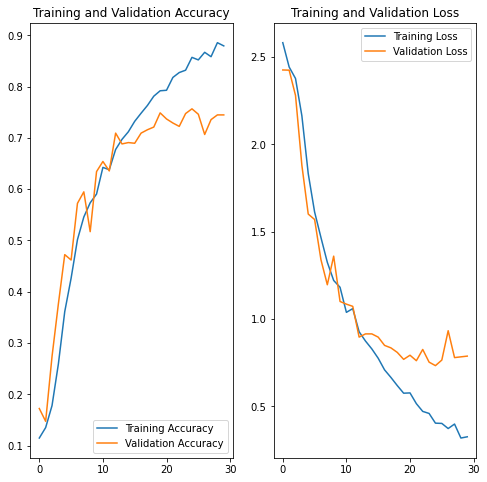

In [65]:
visualize_model_acc_loss_curves(history)

### Observations:
- Both training and validationn accuracies kept inclreassing with each epoch
- The training ad Validation accuracies and losses started diverging after about 14th epoch

In [78]:
y_train_class = np.argmax(y_train_e, axis=1)
y_test_class = np.argmax(y_test_e, axis=1)

In [67]:
m1_train_preds = model_1.predict(X_train)
m1_train_preds = np.argmax(m1_train_preds, axis=1)

m1_test_preds = model_1.predict(X_test)
m1_test_preds = np.argmax(m1_test_preds, axis=1)


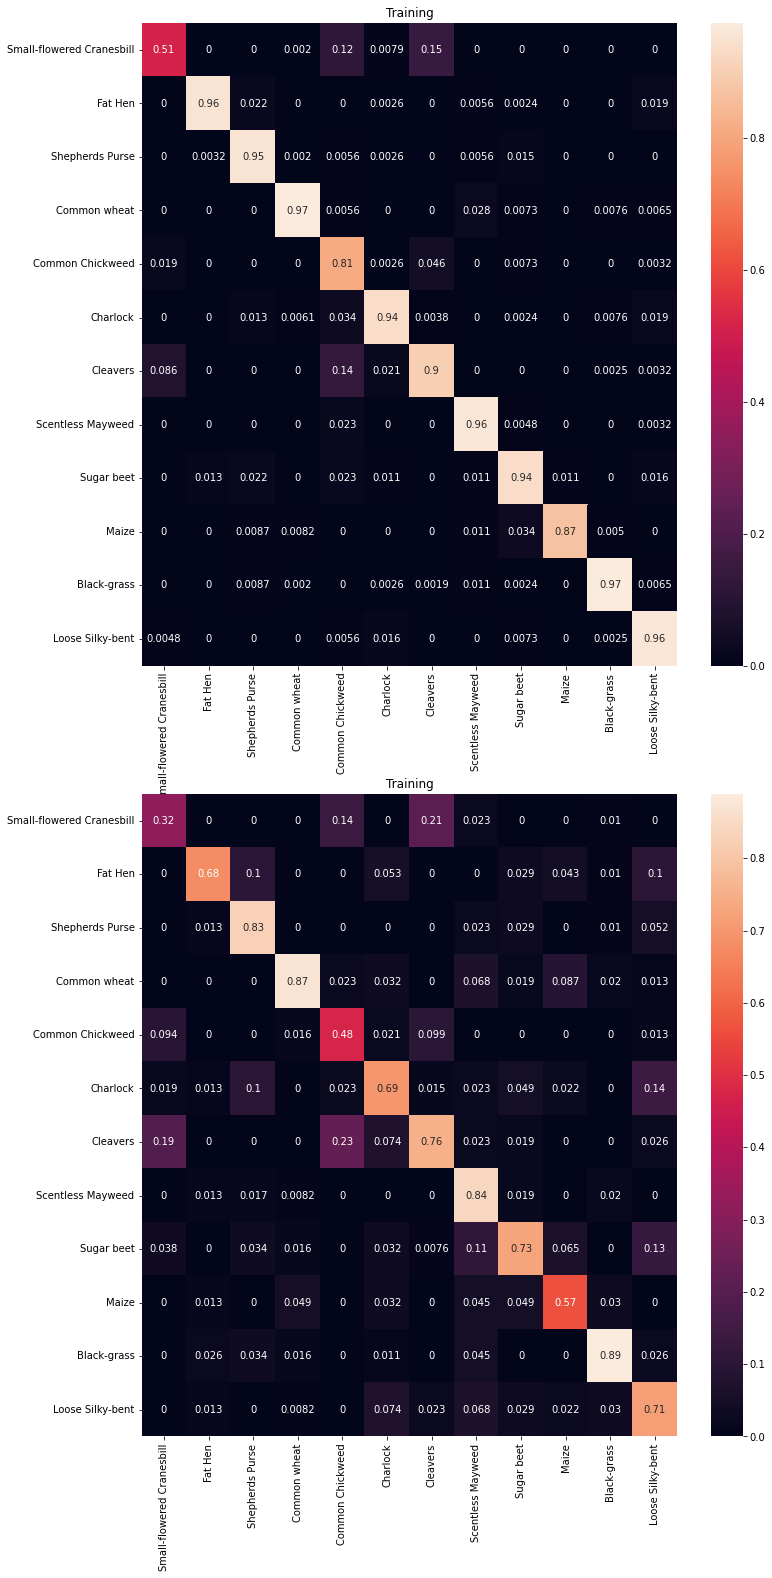

In [81]:
plot_confusion_matrix(y_train_class, y_test_class, m1_train_preds, m1_test_preds, CATEGORIES)

### Observations
- Confussion matrix for training and test look similar. but for most of the cases the perrformance in test is poor compared to training
- In certain cases like Common Chickweed ad Maize, the model perfoormed very will in trainging but inn test it did very poor.


## Model Performance improvements
Lets try to build another CNN model with one more layers added to the model.

In [82]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [83]:
# initialized a sequential model
model_2 = Sequential()

# adding first conv layer
model_2.add(
    Conv2D(
        filters = 256,
        kernel_size = (5,5),
        padding = 'Same', 
        activation ='relu', 
        input_shape = (128,128,3)
    )
)  

# adding max pooling 
model_2.add(MaxPool2D(pool_size=(2,2)))
#  adding dropout 
model_2.add(Dropout(0.25))

#  adding second conv layer 
model_2.add(
    Conv2D(
        filters = 128, 
        kernel_size = (3,3),
        padding = 'Same', 
        activation ='relu'
    )
)
model_2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_2.add(Dropout(0.25))

#  adding third conv layer 
model_2.add(
    Conv2D(
        filters = 128, 
        kernel_size = (3,3),
        padding = 'Same',
        activation ='relu'
    )
)
model_2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_2.add(Dropout(0.3))

#  adding fourth conv layer 
model_2.add(
    Conv2D(
        filters = 128, 
        kernel_size = (3,3),
        padding = 'Same',
        activation ='relu'
    )
)
model_2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_2.add(Dropout(0.3))

# flattening the 3-d output
model_2.add(Flatten())

# adding a fully connected dense layer
model_2.add(
    Dense(
        512, 
        activation = "relu"
    )
)
model_2.add(Dropout(0.5))

# adding the output layer 
model_2.add(Dense(12, activation = "softmax"))

In [84]:
# printing the model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 256)     19456     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)       0

In [85]:
# Using Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compiling the model
model_2.compile(
    optimizer = optimizer , 
    loss = "categorical_crossentropy",
    metrics=["accuracy"]
)

In [86]:
# Fitting the model
es = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0, 
    mode='min', 
    restore_best_weights= True
)
mc = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_accuracy', 
    mode='max', 
    verbose=1, 
    save_best_only=True
)

history = model_2.fit(
    X_train, 
    y_train_e,  
    epochs=50, 
    batch_size=100,
    validation_split=0.20,
    callbacks=[es, mc]
) 

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 2.4732 - accuracy: 0.1099
Epoch 1: val_accuracy improved from -inf to 0.16842, saving model to best_model.h5
31/31 [==============================] - 6s 176ms/step - loss: 2.4732 - accuracy: 0.1099 - val_loss: 2.4286 - val_accuracy: 0.1684
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 2.4357 - accuracy: 0.1303
Epoch 2: val_accuracy did not improve from 0.16842
31/31 [==============================] - 5s 161ms/step - loss: 2.4357 - accuracy: 0.1303 - val_loss: 2.4202 - val_accuracy: 0.1684
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 2.4280 - accuracy: 0.1276
Epoch 3: val_accuracy did not improve from 0.16842
31/31 [==============================] - 5s 161ms/step - loss: 2.4280 - accuracy: 0.1276 - val_loss: 2.4148 - val_accuracy: 0.1487
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 2.4260 - accuracy: 0.1289
Epoch 4: val_accuracy did not improve from 0.1

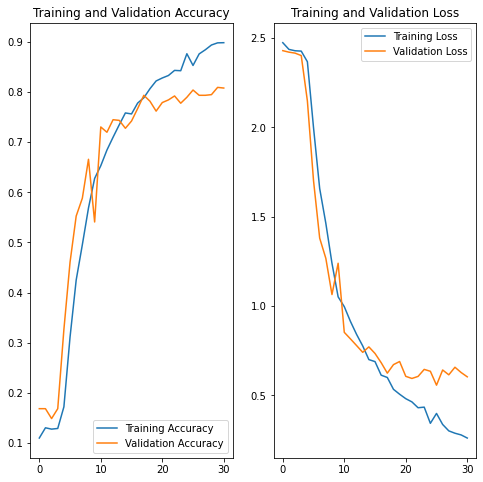

In [87]:
visualize_model_acc_loss_curves(history)

In [89]:
m2_train_preds = model_2.predict(X_train)
m2_train_preds = np.argmax(m2_train_preds, axis=1)

m2_test_preds = model_2.predict(X_test)
m2_test_preds = np.argmax(m2_test_preds, axis=1)


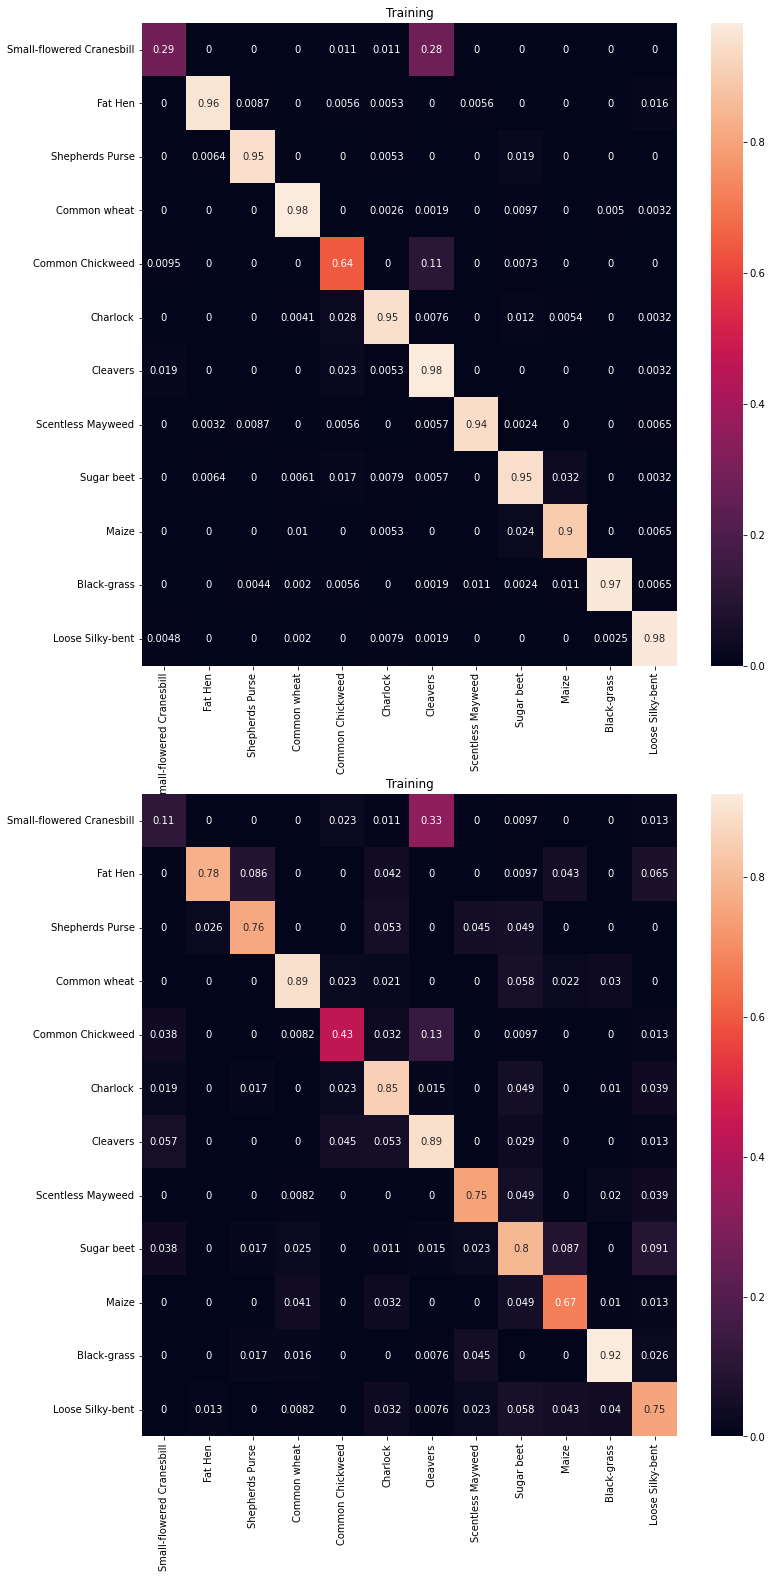

In [90]:
plot_confusion_matrix(y_train_class, y_test_class, m2_train_preds, m2_test_preds, CATEGORIES)

### Observations:
- Model_2 performed better compared to Model_1
- Validationn accuracy improved to 81%
- Reduced overfitting 
- Model_2 used only 31 of the 50 epochs 

# Coonclusion
We were able to develop 2 CNN Models to classify the plant seedlings.<br/>
The second model we built has proved 81% accurate in peredecting the class of thee seedling.<br/>
During the EDA we noticed seedlings of some classses looked similar. The same was noticed in the connfusion matrix for both the models.<br/>
If we can capture more distinguishing images of such confussing, it will be helpful in improving the model.